## CS441: Applied ML - HW 2

## Parts 1-2: MNIST

Include all the code for generating MNIST results below

In [3]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression


def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = x_train[::-1]
  y_train = y_train[::-1]
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 784-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

2025-11-19 15:20:49.389880: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-19 15:20:49.402741: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 15:20:49.915920: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-19 15:20:52.377748: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

### Part 1: PCA and Data Compression

Compute the principal components using sklearn.decomposition.PCA over the full training set.  

a. Display the first 10 principal components using the same
tool that is used to display centroids (`display_mnist`).

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = load_mnist()

# Compute the first 10 principal components using x_train
# Include random_state=0 as an argument when initializing PCA

# TO DO

# Display First 10 Components
pca = PCA(10, random_state=0)
x_train_reduced = pca.fit_transform(x_train)


b. Scatterplot the first two dimensions of PCA-transformed x_train[:500]. Show a different color for each digit label.

<Axes: >

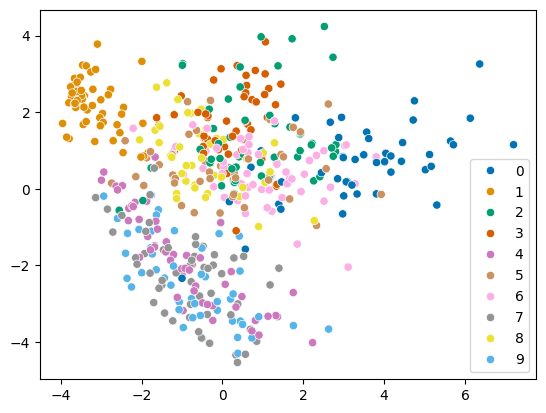

In [3]:
# Scatter plot of first two PCA dimensions
import seaborn as sns

# use pca.transform
# TO DO
x = x_train_reduced
ind = np.arange(500)
sns.scatterplot(x=x[ind,0],y=x[ind,1], hue=y_train[ind], palette="colorblind")

c. Plot cumulative explained variance (explained_variance_ratio_) of all components.

<Axes: >

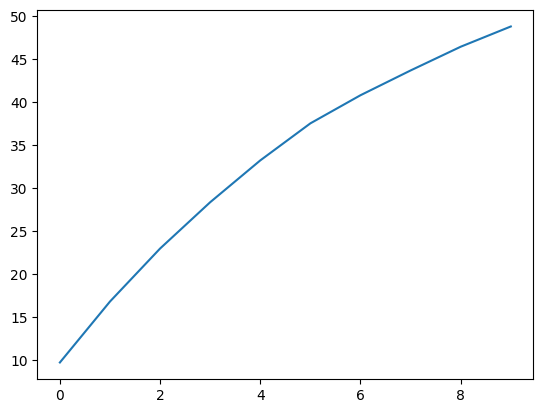

In [4]:
# Plot cumulative explained variance ratio
# cumsum and pca.explained_variance_ratio_ will be useful

# TO DO
# print(pca.explained_variance_ratio_)
cumulative = pca.explained_variance_ratio_.cumsum()
sns.lineplot(cumulative * 100)


d. Select the smallest number M of principal components that explains at least 90% of variance. Then, compress the training data and the test data using the first M principal components, and compute the total time and test error for 1-NN using the brute force Faiss method. Fit PCA on the training data only, then use the same components to transform both training and test data. Compare time and error for 1-NN using original vs compressed features.

In [5]:
# First, find M
for M in range(x_train[0].shape[0]):
    rat_sum = sum(PCA(M, random_state=0).fit(x_train).explained_variance_ratio_)
    if rat_sum * 100 >= 90: break

print(M)
# M = 87

87


In [6]:
# Select number of dimensions that explains 90% of variance, according to your plot above
# !apt install libomp-dev > /dev/null 2>&1
# !pip install faiss-cpu > /dev/null 2>&1
import faiss
import time

#Fit PCA on the training data
pca = PCA(M, random_state=0)
pca.fit(x_train)

# Get time and error when using original features with brute force 1-NN
# TO DO
index = faiss.IndexFlatL2(x_train.shape[1])
index.add(x_train)
start = time.time()
dist, label = index.search(x_test[:], 1)
end = time.time()
print(dist[0], label[0])
time_brute = end - start

# Get time and error when using compressed features with brute force 1-NN
# TO DO
x_train_trans, x_test_trans = pca.transform(x_train), pca.transform(x_test)
index_trans = faiss.IndexFlatL2(x_train_trans.shape[1])
index_trans.add(x_train_trans)
start_trans = time.time()
dist_trans, label_trans = index_trans.search(x_test_trans[:], 1)
end_trans = time.time()
time_trans = end_trans - start_trans

print(f"Times: original: {time_brute}, transformed: {time_trans}")



[7.0398407] [6156]
Times: original: 62.79454970359802, transformed: 17.252588510513306


In [7]:
#Next, calculate the errors.
# print (np.sum(y_test - y_train[label_trans.flatten()]))

err = np.sqrt(np.mean((y_test - y_train[label.flatten()]) ** 2))
err_trans = np.sqrt(np.mean((y_test - y_train[label_trans.flatten()]) ** 2))

print(f"Errors: Original: {err}, transformed: {err_trans}")

Errors: Original: 0.7360706487831178, transformed: 0.6926037828369117


### Part 2: MNIST Classification with Linear Models

We revisit classification using linear logistic regression (LLR) and SVM. For logistic regression, use `sklearn.linear_model.LogisticRegression` with default parameters (unless stated otherwise), except `max_iter=500`. For SVM, use `sklearn.svm.LinearSVC` with default parameters, except `max_iter=500`.  Do not use `svm.SVC` since that is a non-linear SVM by default.  With  `max_iter=500`, it's ok if you get a warning that it hasn’t converged.  

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

a. LLR/SVM vs training size: For varying size training sets N in [100, 1000, 10000, 60000], compare and tabulate classification error for linear logistic regression and linear SVM, using x_train[:N] and x_test.    

In [9]:
# LLR
# TO DO
sizes = [100, 1000, 10000, 60000]
# llr = LogisticRegression(max_iter=500).fit(x_train[:100], y_train[:100])
# labels = llr.predict(x_test)
# print(np.max(labels))
# err = np.sqrt(np.mean((y_test - labels)**2))
# print(err)
llrs = np.array([LogisticRegression(max_iter=500).fit(x_train[:N], y_train[:N]) for N in sizes])


In [10]:
# SVM
# TO DO
svcs = np.array([LinearSVC(max_iter=500).fit(x_train[:N], y_train[:N]) for N in sizes])
# svc_labels = np.array([s.predict(x_test) for s in svcs])

b. Error visualization: For each LLR and SVM, for each label (0 to 9), display the sample with the highest score for the *correct label*. E.g., out of all samples with a true label of 0, select the one that has the highest score for label 0. Display the 10 samples in a row for each method, showing the easy cases for each model.  Then, for each label, display the sample with the lowest score for the correct label. Again, display the 10 samples in a row, showing the difficult cases.

In [ ]:
# to get scores for logistic regression use: scores = model_lr.predict_proba(x_test)
# TO DO
llr_scores = np.array([l.predict_proba(x_test) for l in llrs])

# to get scores for SVM use: scores = model_svm.decision_function(x_test)
# TO DO
svc_scores = np.array([s.decision_function(x_test) for s in svcs])

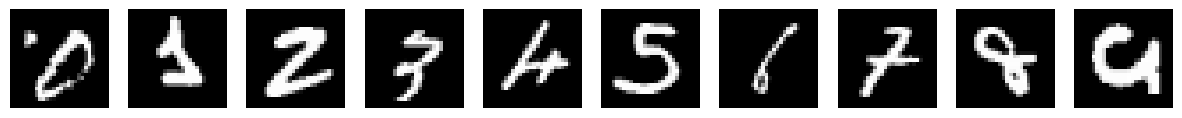

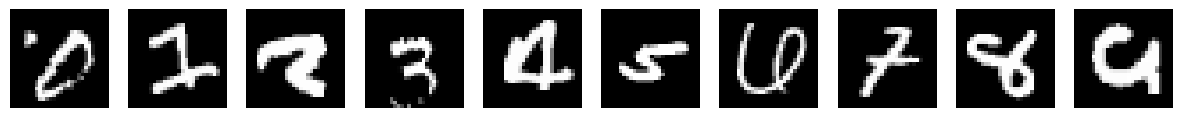

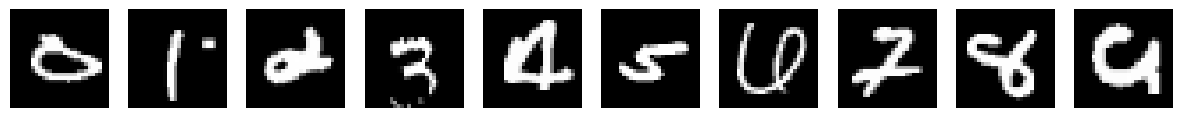

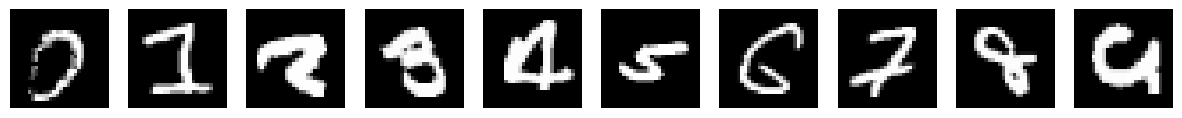

In [ ]:
# llr = llr_scores[-1]
# l = 0
# labels_zero = np.where(y_test == l)[0]
# m = labels_zero[np.argmax(llr[labels_zero][:, l])]
# display_mnist(x_test[m])

# This shows the most difficult cases for the llrs, won't do the rest cos it's repititive. Just switch `llr_scores` with `svc_scores` to change the models
# And switch `np.argmin` with `np.argmax` to get the easiest test cases
for llr in llr_scores:
    samples = []
    for l in range(10):
        true_labels = np.where(y_test == l)[0]
        m = true_labels[np.argmin(llr[true_labels][:, l])]
        samples.append(m)
    display_mnist(x_test[samples], 1, 10)

c. Parameter selection: For linear SVM, use validation experiments (testing on the validation set) to estimate the best regularization strength `C`. Then evaluate a model trained with that C on the test set. For the sake of speed, in this section, use  `x_train[:1000]` as the training set for all experiments, with `max_iter=1000`.  For the validation set, use `x_train[50000:]`.

In selection, try to get the best result on the validation set within 0.1%.  To select `C`, start with the default and increase/decrease by a factor of 2 until results either level out or start to get worse. Then, you can try half way between the most two best values. E.g. try `C` in [0.25, 0.5, 1, 2, 4].  Suppose 0.5 and 1 give the best results.  Then, try 0.75.  Once the difference between the two best results is less than 0.1%, you can stop. You can also search outside of this range if 0.25 or 4 gives the best result.  Plot the validation error for each `C` value tested on a semilogx plot, and record the best in a table.

Note that you do not need to have a script that automatically searches over `C`.  You can try some values and manually choose the next `C` to try.  But you need to plot all the tested `C` and corresoning validation error together, so be sure to record the results.

0.001     : 1.9441964921272747
0.01      : 1.836627343801676
0.02      : 1.8249657531033288
0.03      : 1.8244725265128001
0.05      : 1.8388855320546735
0.1       : 1.8808508712813996
0.25      : 1.9226284092356485
0.5       : 1.9433990840792326
1.0       : 1.9705329228409252
2.0       : 1.9752721331502654
4.0       : 1.9763602910400726
Best C: 0.03


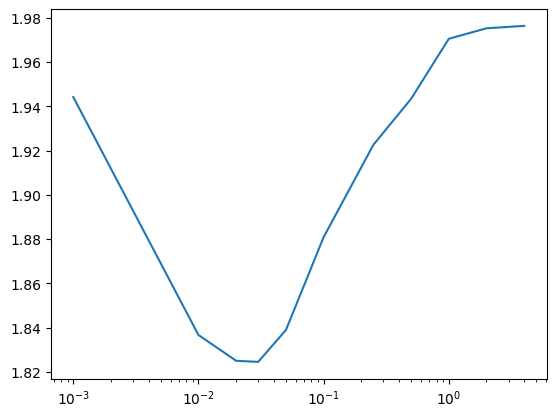

In [41]:
# Try multiple C parameters, select one that minimizes validation error
# Often, you need to try a few values and see those results to determine what other values to try
# TO DO
Cs = np.array([0.001, 0.01, 0.02, 0.03, 0.05, 0.1, 0.25, 0.5, 1, 2, 4])
errs = []
for c in Cs:
    svc = LinearSVC(max_iter=1000, C=c).fit(x_train[:1000], y_train[:1000])
    y_pred = svc.predict(x_train[50000:])
    err = np.sqrt(np.mean((y_train[50000:] - y_pred)**2))
    errs.append(err)
    print(f"{c:<10}: {err:>10}")
errs = np.array(errs)

best_C = Cs[np.argmin(errs)]
print(f"Best C: {best_C}")

import matplotlib.pyplot as plt
plt.semilogx(Cs, errs)
plt.show()


In [42]:
# Get test result for selected parameter
svc = LinearSVC(max_iter=1000, C=best_C).fit(x_train, y_train)
y_pred = svc.predict(x_test)
# TO DO

## Part 3: Temperature Regression

We will investigate using linear regression for both prediction and feature selection.


In [47]:
import numpy as np
# from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# load data (modify to match your data directory or comment)
def load_temp_data():
  # drive.mount('/content/drive')
  datadir = "../data/"
  T = np.load(datadir + 'temperature_data.npz')
  xt_train, yt_train, xt_val, yt_val, xt_test, yt_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (xt_train, yt_train, xt_val, yt_val, xt_test, yt_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target date
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()


Feature 361: city = Cleveland, day= -1
Baseline - prediction using previous day: RMSE=3.460601246750482


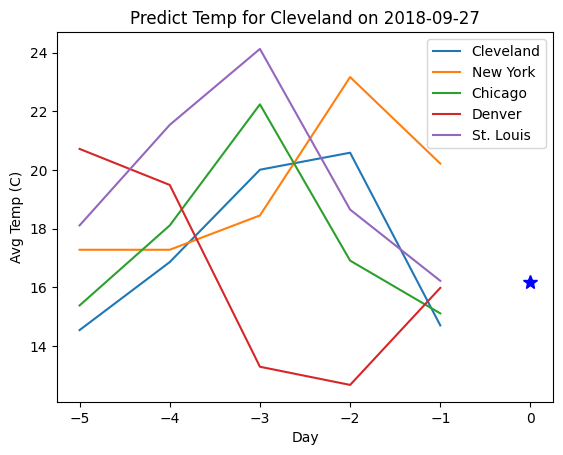

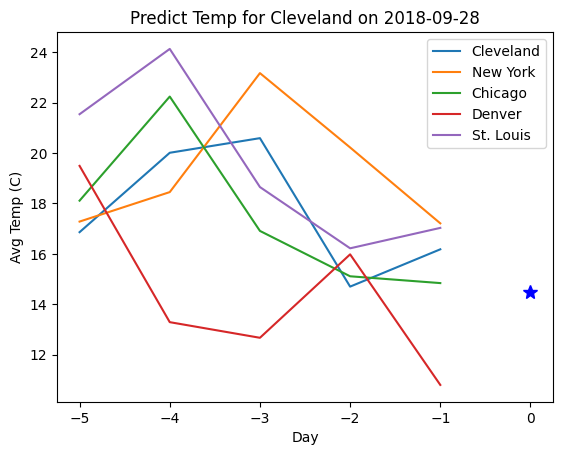

In [48]:
# load data
(xt_train, yt_train, xt_val, yt_val, xt_test, yt_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()
''' Data format:
      x_train, y_train: features and target value for each training sample (used to fit model)
      x_val, y_val: features and target value for each validation sample (used to select hyperparameters, such as regularization and K)
      x_test, y_test: features and target value for each test sample (used to evaluate final performance)
      dates_xxx: date of the target value for the corresponding sample
      feature_to_city: maps from a feature number to the city
      feature_to_day: maps from a feature number to a day relative to the target value, e.g. -2 means two days before
      Note: 361 is the temperature of Cleveland on the previous day
'''
f = 361
print('Feature {}: city = {}, day= {}'.format(f,feature_to_city[f], feature_to_day[f]))
baseline_rmse = np.sqrt(np.mean((yt_val[1:]-yt_val[:-1])**2)) # root mean squared error
print('Baseline - prediction using previous day: RMSE={}'.format(baseline_rmse))

# plot first two x/y for val
plot_temps(xt_val[0], yt_val[0], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[0])
plot_temps(xt_val[1], yt_val[1], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[1])



a. Train and Test Linear Regression (LR):
Report RMSE results for L2-regularized linear regression (`sklearn.linear_model.Ridge`)  using default regularization parameters on the temperature regression dataset, using original and normalized features (based on feature number 361, as defined in HW1). When normalizing, remember to normalize both the training and the test sets.

In [49]:
def normalize_features(x, y, fnum):
  ''' Normalize the features in x and y.
      For each data sample i:
        x2[i] = x[i]-x[i,fnum]
        y2[i] = y[i]-x[i,fnum]
  '''
  x2 = x.copy()
  y2 = y.copy()
  for i in np.arange(len(x)):
    x2[i] = x[i] - x[i, fnum]
    y2[i] = y[i] - x[i,fnum]
  return x2, y2

In [ ]:
 # linear regression (use Ridge)

# original features
# TO DO

# normalized features
# TO DO

b. Feature selection: Use original features for this part.  Identify the most important features by: (1) fitting a L1 Linear Regression model (`sklearn.linear_model.Lasso`) with default parameters; and (2) selecting the features that have coefficient magnitudes greater than 0.001 (`model.coef_` is the linear coefficient vector; -0.02 and 0.02 both have magnitude greater than 0.001).  For the top 10 features, report their indices and corresponding city and day. Also report the test RMSE error rates of L2 (ridge) linear regression when trained using only the top 10 selected features.

In [ ]:
# feature analysis (select important features using Lasso)
# TO DO

# predict using best features
# TO DO

## Part 4: Stretch Goals
Include all your code used for any stretch goals in this section. Add headings where appropriate.

In [ ]:
# TO DO (optional)

In [ ]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/MyDrive/CS441/hw2" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_HW2_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!apt install pandoc > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")